# LIDO Learning - Assignment

# Goal

* We want to optimize the class_interval. Ideal class_interval (Class Duration) should be 55 minutes.
* We want to find what are the other parameters that has statistically significant impact on class_interval.
* Visually represent the conclusion of the findings. 

#### Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np

from scipy.stats import skew
import pandas_profiling

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.gridspec as gridspec
from scipy import stats
import matplotlib.style as style

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import r2_score

import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax


#### Helper functions

In [2]:
def missing_percentage(df):
    '''
    Function to display missing percentage in the dataset
    '''    
    total = df.isnull().sum().sort_values(ascending = False)[df.isnull().sum().sort_values(ascending = False) != 0]
    percent = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)[round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])

def one_hot_encoder(df, columns):
    '''
    Function to do one-hot encoded pandas dataframe
    '''
    for each in columns:
        print("One-Hot encoding column - {0}".format(each))
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df.drop(columns,axis = 1)

def plotting_3_chart(df, feature):
    
    '''
    Custom function for for plotting histogram, QQ and box plot together
    '''
    style.use('fivethirtyeight')

    ## Creating a customized chart. and giving in figsize and everything. 
    fig = plt.figure(constrained_layout=True, figsize=(15,10))
    ## creating a grid of 3 cols and 3 rows. 
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    #gs = fig3.add_gridspec(3, 3)

    ## Customizing the histogram grid. 
    ax1 = fig.add_subplot(grid[0, :2])
    ## Set the title. 
    ax1.set_title('Histogram')
    ## plot the histogram. 
    sns.distplot(df.loc[:,feature], norm_hist=True, ax = ax1)

    # customizing the QQ_plot. 
    ax2 = fig.add_subplot(grid[1, :2])
    ## Set the title. 
    ax2.set_title('QQ_plot')
    ## Plotting the QQ_Plot. 
    stats.probplot(df.loc[:,feature], plot = ax2)

    ## Customizing the Box Plot. 
    ax3 = fig.add_subplot(grid[:, 2])
    ## Set title. 
    ax3.set_title('Box Plot')
    ## Plotting the box plot. 
    sns.boxplot(df.loc[:,feature], orient='v', ax = ax3 )

def fixing_skewness(df):
    """
    This function takes in a dataframe and return fixed skewed dataframe
    """
    ## Getting all the data that are not of "object" type. 
    numeric_feats = df.dtypes[df.dtypes != "object"].index

    # Check the skew of all numerical features
    skewed_feats = df[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)
    high_skew = skewed_feats[abs(skewed_feats) > 0.5]
    skewed_features = high_skew.index

    for feat in skewed_features:
        df[feat] = boxcox1p(df[feat], boxcox_normmax(df[feat] + 1))    
    

##### Loading the input data and gathering some statistical information about the dataset

In [19]:
data = pd.read_csv('query_result.csv')
print (f"Dataset has {data.shape[0]} rows and {data.shape[1]} columns")
data.head()

Dataset has 2000 rows and 14 columns


,channel,first_slide_time,class_interval,total_slide_transitions,total_slide_count,drawing_on_whiteboard,drawing_on_slides,students_connected_count,course_slug,languages,max_aptitude,time_slot,ninety_rtt,lesson_slug
0,3d1a792e-d7d9-4dcd-a453-f7d63c67570b,2019-10-07T15:16:24.980+05:30,45.533117,86,28,111,367,1,M_CBSE_6,"[""English""]",2,15:30,78.0,M_NS_NNI_L_11
1,0e0f8bba-4af4-49af-bc5a-f000e2209691,2019-10-07T15:27:44.036+05:30,60.685817,70,28,370,428,1,M_CBSE_6,"[""English""]",3,15:30,20318.0,M_NS_NNI_L_11
2,ba14d56a-b3c9-4233-9578-5750055abb6e,2019-10-07T15:31:02.585+05:30,57.808833,35,28,33,209,3,M_CBSE_6,"[""Hinglish""]",3,15:30,76.0,M_NS_NNI_L_11
3,b98cf5ee-27f5-4936-a0d6-9c6822bc5e27,2019-10-07T15:32:01.908+05:30,45.037433,29,28,64,167,1,M_CBSE_6,"[""Hinglish""]",2,15:30,29.0,M_NS_NNI_L_11
4,884c0b8a-0071-4cda-a14a-a9c989f87738,2019-10-07T15:33:17.953+05:30,48.267917,43,41,115,768,1,M_CBSE_5,"[""Hinglish""]",1,15:30,45.0,M_NS_FN_L_6


In [4]:
## Some information about the features datatypes. 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
channel                     2000 non-null object
first_slide_time            2000 non-null object
class_interval              2000 non-null float64
total_slide_transitions     2000 non-null int64
total_slide_count           2000 non-null int64
drawing_on_whiteboard       2000 non-null int64
drawing_on_slides           2000 non-null int64
students_connected_count    2000 non-null int64
course_slug                 2000 non-null object
languages                   2000 non-null object
max_aptitude                2000 non-null int64
time_slot                   1977 non-null object
ninety_rtt                  1999 non-null float64
lesson_slug                 1986 non-null object
dtypes: float64(2), int64(6), object(6)
memory usage: 218.8+ KB


In [5]:
# determining variance of the dataset
data.nunique()

channel                     2000
first_slide_time            2000
class_interval              1999
total_slide_transitions      218
total_slide_count             46
drawing_on_whiteboard        462
drawing_on_slides            826
students_connected_count       6
course_slug                   19
languages                      2
max_aptitude                   3
time_slot                      5
ninety_rtt                   358
lesson_slug                  112
dtype: int64

#### Observations
- Channel is a ID field, would not add value to model. We may drop it.
- Though first_slide_time is a timestamp, we already have the mapped value to time_slot. Hence, we may drop it.
- Few fields like languages,max_aptitude etc has low variance: would not impact model much. We can observe them.
- Though fields like course_slug and lesson_slug ought to be identifiers, they might some relation to target.

In [6]:
# looking for missing values
missing_percentage(data)

,Total,Percent
time_slot,23,1.15
lesson_slug,14,0.70
ninety_rtt,1,0.05


* Only few features have missing values. 

Let's focus on the target variable which is **class_interval.** Let's create a histogram to see if the target variable is Normally distributed. If we want to create any linear model, it is essential that the features are normally distributed. This is one of the assumptions of multiple linear regression.

Skewness: 30.44635892449766
Kurtosis: 1199.5899338560482


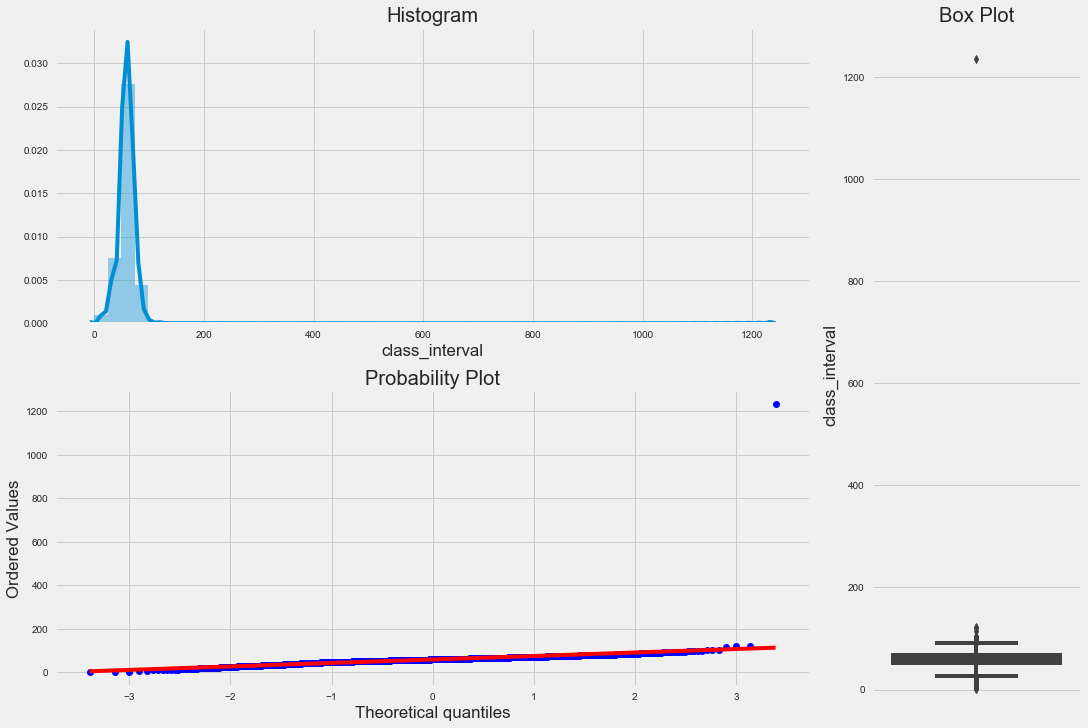

In [7]:
plotting_3_chart(data, 'class_interval')

#skewness and kurtosis
print("Skewness: " + str(data['class_interval'].skew()))
print("Kurtosis: " + str(data['class_interval'].kurt()))

These **three** charts above can tell us a lot about our target variable.
* Our target variable, **class_interval** is not normally distributed.
* Our target variable is right-skewed. In Layman's terms, more classes have higher interval than the average class interval. 
* There are multiple outliers in the variable.

We need to address these outliers for any linear regression attempt.

Skewness: -0.3642200251355776
Kurtosis: 1.465625683025901


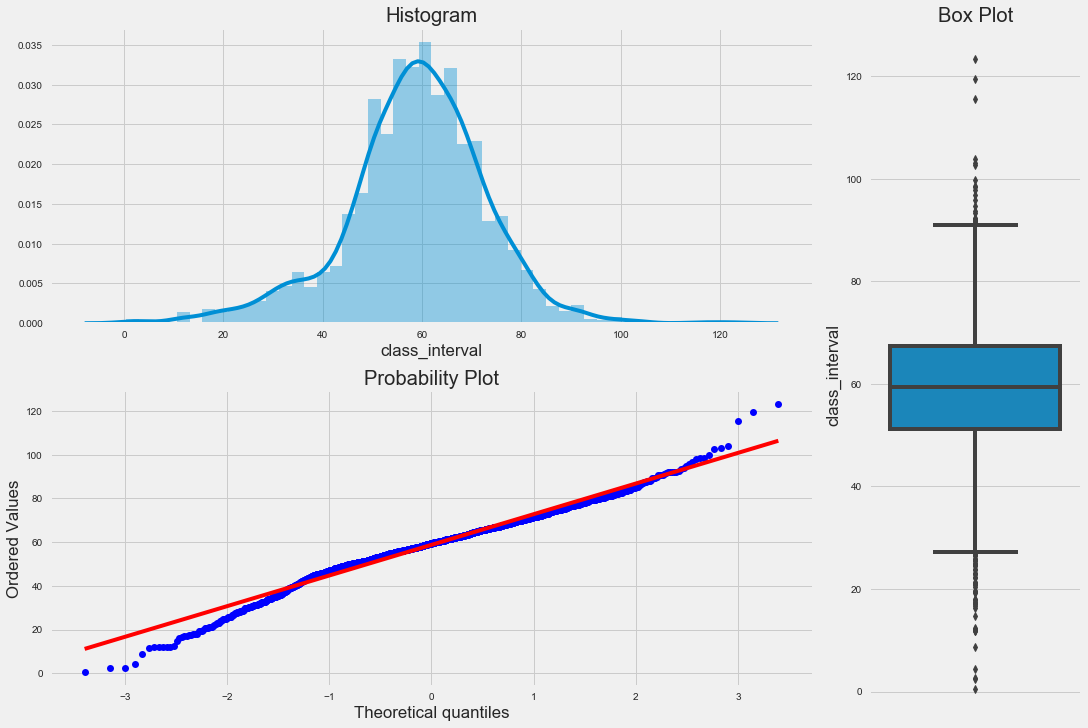

In [20]:
# class_interval- our probable target column seems to have outlier
data.loc[data.class_interval>500.0]
data.drop(data.index[121],inplace=True)

# ninety_rtt- also seems to have outlier value like 20000
data.loc[data.ninety_rtt>5000.0]
data.drop(data.index[1],inplace=True)

#skewness and kurtosis
print("Skewness: " + str(data['class_interval'].skew()))
print("Kurtosis: " + str(data['class_interval'].kurt()))

# we remove these records and try re-plotting
plotting_3_chart(data, 'class_interval')

After dropping the single outlier, Our target variable looks normally distributed now which is good for linear model assumption.

Let's understand the statistical characteristics of our feature set next.

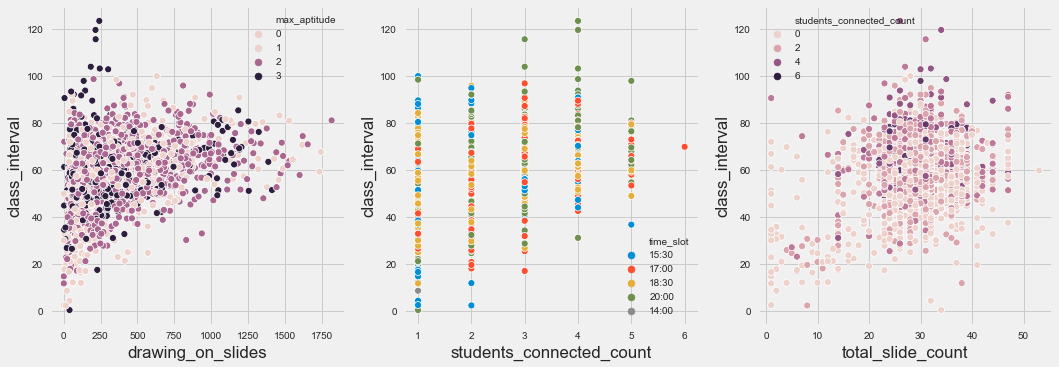

In [22]:
plt.figure(figsize=[16,12])
plt.subplot(231)
ax = sns.scatterplot(x="drawing_on_slides", y="class_interval",hue="max_aptitude",data=data)
plt.subplot(232)
ax = sns.scatterplot(x="students_connected_count", y="class_interval",hue="time_slot",data=data)
plt.subplot(233)
ax = sns.scatterplot(x="total_slide_count", y="class_interval",hue="students_connected_count",data=data)
#ax = sns.residplot(data.drawing_on_slides, data.class_interval);

* Plots exhibit peculiar patterns like funnel shape which is bad for linear model. It also detects some outlier values. 
* Though Students connected count is categorical entity, it shows few late classes has very high class intervals.
* There are few cases where few students connected with slide count being extremely low or high.

In [10]:
# statistical information - on numeric fields present in dataset
data.describe()

,class_interval,total_slide_transitions,total_slide_count,drawing_on_whiteboard,drawing_on_slides,students_connected_count,max_aptitude,ninety_rtt
count,1998.000000,1998.000000,1998.000000,1998.000000,1998.000000,1998.000000,1998.000000,1997.000000
mean,58.764319,67.420921,29.258759,121.110611,374.683183,1.979479,1.981481,114.616925
std,14.175202,47.377299,7.206769,184.004184,305.955381,1.079735,0.699207,167.064410
min,0.433383,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,3.000000
25%,51.160242,38.000000,26.000000,6.000000,134.000000,1.000000,1.000000,46.000000
50%,59.470125,51.000000,30.000000,38.000000,300.000000,2.000000,2.000000,71.000000
75%,67.355400,85.000000,33.000000,173.000000,526.000000,3.000000,2.000000,127.000000
max,123.346817,556.000000,53.000000,1856.000000,1817.000000,6.000000,3.000000,3781.000000


Next we gauge skewness in the numerical feature set**

In [11]:
numeric_feats = data.dtypes[data.dtypes != "object"].index

skewed_feats = data[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)

skewed_feats

drawing_on_whiteboard       2.935769
total_slide_transitions     2.591501
drawing_on_slides           1.350485
students_connected_count    0.926458
max_aptitude                0.025279
class_interval             -0.363947
total_slide_count          -0.954145
ninety_rtt                       NaN
dtype: float64

Seems like few variables are proportionately skewed. We can use boxcox to fix the skewness.

In [12]:
# Fixing Skewed features using boxcox transformation.
fixing_skewness(data)

# measuring skewness in data
numeric_feats = data.dtypes[data.dtypes != "object"].index
skewed_feats = data[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)
skewed_feats

students_connected_count    0.534337
total_slide_transitions     0.213894
total_slide_count           0.136998
drawing_on_whiteboard       0.027749
max_aptitude                0.025279
drawing_on_slides          -0.021569
class_interval             -0.363947
ninety_rtt                       NaN
dtype: float64

Now that our data is standardized, Let's see the distribution of our target variable along few feature set.

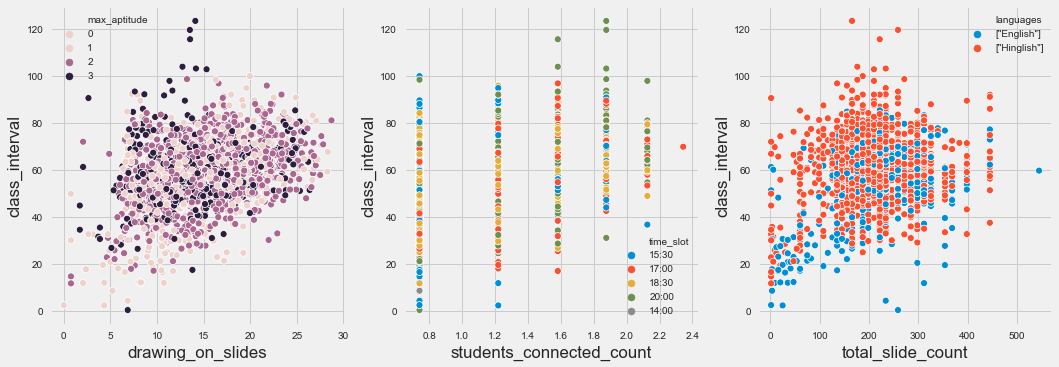

In [13]:
plt.figure(figsize=[16,12])
plt.subplot(231)
ax = sns.scatterplot(x="drawing_on_slides", y="class_interval",hue="max_aptitude",data=data)
plt.subplot(232)
ax = sns.scatterplot(x="students_connected_count", y="class_interval",hue="time_slot",data=data)
plt.subplot(233)
ax = sns.scatterplot(x="total_slide_count", y="class_interval",hue="languages",data=data)
#ax = sns.residplot(data.drawing_on_slides, data.class_interval);

* Plots does not exhibit any peculiar pattern (eg.funnel) which is good. 
* Students connected count shows decimal values after feature transformation.  
* Next, we will look at the correlation heatmap to understand any multicollinearity.

drawing_on_slides           0.097538
students_connected_count    0.087887
total_slide_count           0.084399
drawing_on_whiteboard       0.069706
total_slide_transitions     0.004208
max_aptitude                0.002841
ninety_rtt                  0.001161
Name: class_interval, dtype: float64


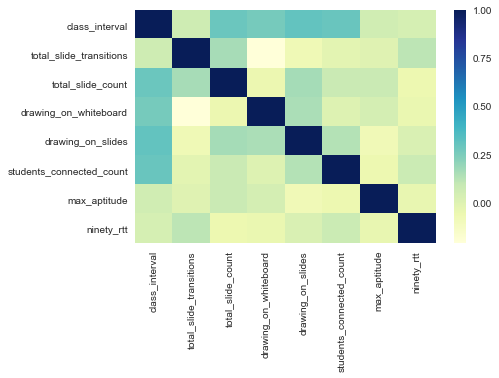

In [32]:
# obtaining correlation values
print((data.corr()**2)["class_interval"].sort_values(ascending = False)[1:])

# generating heatmap
style.use('ggplot')
sns.set_style('whitegrid')
sns.heatmap(data.corr(),cmap="YlGnBu")

In [ ]:
#generating dataframe profile
data.profile_report(style={'full_width':True})

## Fitting into a linear regression model (simple approach)
* We will impute the missing values and encode the categorical fields before fitting to model.
* Since there were outlier observed in our plots, we could limit the data to +-3 std. deviation for our model.
* We will train our model on 80% of the processed dataset and test it on remaining 20%.
* We will use R2 to determine goodness-of-fit and p-values to obtain variable importance.

In [38]:
print(" *** imputing numerical fields with mean *** ")
print("\n")
for i in data.select_dtypes(include=np.number).columns:
    print("Filling missing values with mean for colmns - {0}".format(i))
    data.ix[:,i] = data.ix[:,i].fillna(data.ix[:,i].mean())
print("\n")
print(" *** imputing categorical fields with mode *** ")
print("\n")    
for i in data.select_dtypes(include='object').columns:
    print("Filling missing values with mode for colmns - {0}".format(i))
    data.ix[:,i] = data.ix[:,i].fillna(data.ix[:,i].mode()[0])

 *** imputing numerical fields with mean *** 


Filling missing values with mean for colmns - class_interval
Filling missing values with mean for colmns - total_slide_transitions
Filling missing values with mean for colmns - total_slide_count
Filling missing values with mean for colmns - drawing_on_whiteboard
Filling missing values with mean for colmns - drawing_on_slides
Filling missing values with mean for colmns - students_connected_count
Filling missing values with mean for colmns - max_aptitude
Filling missing values with mean for colmns - ninety_rtt


 *** imputing categorical fields with mode *** 


Filling missing values with mode for colmns - channel
Filling missing values with mode for colmns - first_slide_time
Filling missing values with mode for colmns - course_slug
Filling missing values with mode for colmns - languages
Filling missing values with mode for colmns - time_slot
Filling missing values with mode for colmns - lesson_slug


C:\Users\abhranshu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
C:\Users\abhranshu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()


In [44]:
print(" *** Limiting the data in +-3 Std Deviation *** ")
data_std_dev = data[np.abs(data.class_interval-data.class_interval.mean()) <= (3*data.class_interval.std())]
print("\nShape of the filtered dataset: {}".format(data_std_1.shape))

 *** Limiting the data in +-3 Std Deviation *** 

Shape of the filtered dataset: (1979, 14)


In [56]:
data_no_ohe = data_std_dev.drop(['first_slide_time','channel'],axis=1)
#data_no_ohe = data_std_dev.drop(['first_slide_time','channel','max_aptitude','ninety_rtt','languages','total_slide_transitions'],axis=1)
#data_no_ohe = data_std_dev.drop(['first_slide_time','channel','languages','course_slug','lesson_slug','ninety_rtt','max_aptitude'],axis=1)

# OHE the categorical data
data_enc = one_hot_encoder(data_no_ohe,data_no_ohe.select_dtypes(include='object').columns)
#data_enc = one_hot_encoder(data,['first_slide_time', 'course_slug', 'time_slot','lesson_slug'])

# Setting up features and target variables
X = data_enc.drop('class_interval',axis=1)
y = data_enc['class_interval']

# Splitting the dataset into training and test set
X_train, X_test, y_train, y_test =  train_test_split(X,y,test_size = 0.2, random_state= 42)

# fitting training data in a Regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

#predicting the test set results
y_pred = regressor.predict(X_test)

#obtaining R2 value for the model fit
obtained_R2 = r2_score(y_test,regressor.fit(X_train,y_train).predict(X_test))

print("******************************************")
print("obtained_R2 with LR is:{} ".format(obtained_R2))
print("******************************************")


One-Hot encoding column - course_slug
One-Hot encoding column - languages
One-Hot encoding column - time_slot
One-Hot encoding column - lesson_slug
******************************************
obtained_R2 with LR is:0.39434867661006934 
******************************************


In [55]:
# obtaining ols model summary 
Xc = sm.add_constant(X_train)

linear_regression = sm.OLS(y_train, Xc)
fitted_model = linear_regression.fit()

fitted_model.summary()

C:\Users\abhranshu\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         class_interval   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     9.507
Date:                Wed, 08 Jan 2020   Prob (F-statistic):          7.92e-122
Time:                        01:28:29   Log-Likelihood:                -5840.1
No. Observations:                1583   AIC:                         1.194e+04
Df Residuals:                    1451   BIC:                         1.265e+04
Df Model:                         131                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            18.5875      1.509     12.319      0.000      15.628      21.547
total_slide_transitions           0.0358      0.008      4.480      0.000       0.020       0.051
total_slide_count                 0.4367      0.068      6.422      0.000       0.303       0.570
drawing_on_whiteboard             0.0147      0.002      8.894      0.000       0.011       0.018
drawing_on_slides                 0.0061      0.001      6.119      0.000       0.004       0.008
students_connected_count          3.0666      0.270     11.356      0.000       2.537       3.596
max_aptitude                     -0.0664      0.411     -0.161      0.872      -0.873       0.741
ninety_rtt                        0.0009      0.002      0.562      0.575      -0.002       0.004
course_slug_M_CBSE_5              5.6449      6.148      0.918      0.359      -6.415      17.705
course_slug_M_CBSE_6              2.8598      6.116      0.468      0.640      -9.137      14.857
course_slug_M_CBSE_7             -2.2904     10.726     -0.214      0.831     -23.331      18.750
course_slug_M_CBSE_8              7.1825      1.573      4.568      0.000       4.098      10.267
course_slug_M_ICSE_5              2.1674      8.411      0.258      0.797     -14.332      18.667
course_slug_M_ICSE_6              6.0553      8.405      0.720      0.471     -10.433      22.543
course_slug_M_ICSE_7             -7.8029     11.061     -0.705      0.481     -29.501      13.895
course_slug_M_ICSE_8              2.4093      3.285      0.734      0.463      -4.034       8.852
course_slug_M_SC_Rev_Course    3.721e-16   9.73e-14      0.004      0.997    -1.9e-13    1.91e-13
course_slug_M_TUTOR_TRAINING    -26.7803      3.861     -6.936      0.000     -34.355     -19.206
course_slug_SC_CBSE_5             5.8373      4.830      1.209      0.227      -3.637      15.311
course_slug_SC_CBSE_6            -1.1372      5.467     -0.208      0.835     -11.861       9.587
course_slug_SC_CBSE_7             6.7622      4.902      1.379      0.168      -2.854      16.378
course_slug_SC_CBSE_8             0.8775      4.948      0.177      0.859      -8.828      10.583
course_slug_SC_ICSE_5            16.3049      6.950      2.346      0.019       2.672      29.938
course_slug_SC_ICSE_6             9.4819      4.952      1.915      0.056      -0.233      19.197
course_slug_SC_ICSE_7             6.2461      5.941      1.051      0.293      -5.407      17.899
course_slug_SC_ICSE_8             2.6615     10.941      0.243      0.808     -18.801      24.124
course_slug_SC_TUTOR_TRAINING   -17.8924      4.692     -3.813      0.000     -27.097      -8.688
languages_["English"]             8.6273      0.855     10.087      0.000       6.949      10.305
languages_["Hinglish"]            9.9603     

### Observations
* We have obtained a R2 value of 0.46, which is not bad considering sample size and basic preprocessing steps before model fitting.
* features like **max_aptitude**, **course_slug=M_SC_Rev_Course** etc. to list a few, shows p-values much higher than 0.05 and thus 
* can be expelled from the fit as they are less significant. In hindsight, variables with p-values less than 0.05 are important.
* Further, we could used Ridge,Lasso regression to tackle multicollinearity. 
* Feature engineering and a good sample size can further improve the model.

In [50]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
print ('%.2f'%mean_squared_error(y_test, y_pred))

116.14


In [51]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
lin_reg = LinearRegression()
cv = KFold(shuffle=True, random_state=2, n_splits=10)
scores = cross_val_score(lin_reg, X,y,cv = cv, scoring = 'neg_mean_absolute_error')
print ('%.8f'%scores.mean())

-13569477.72941179


In [52]:
result_df = data.ix[X_test.index].copy()
result_df['pred_class_interval'] = y_pred
result_df['difference'] = result_df['class_interval']-result_df['pred_class_interval']
result_df[['class_interval','pred_class_interval','difference']].head()

C:\Users\abhranshu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


,class_interval,pred_class_interval,difference
571,55.326650,68.469206,-13.142556
100,45.983167,51.464280,-5.481113
1065,51.749283,54.484750,-2.735467
1699,49.260850,46.735049,2.525801
1523,57.301883,57.127180,0.174703


<Figure size 1152x864 with 0 Axes>

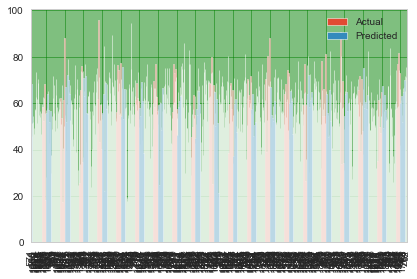

In [53]:
plt.figure(figsize=[16,12])
df1 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1.plot(kind='bar')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()